<a href="https://colab.research.google.com/github/jktluna/WasteReduxImageClassification/blob/main/CopyOfImageClassification1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflowjs

In [2]:
!pip install tensorflow-model-optimization

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.layers import InputLayer
from tensorflow.keras import layers

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder_path = '/content/drive/MyDrive/path/ColabNotebooks'

In [6]:
data_train_path = '/content/drive/MyDrive/ColabNotebooks/basedata/train'
data_val_path = '/content/drive/MyDrive/ColabNotebooks/basedata/validation'
data_test_path = '/content/drive/MyDrive/ColabNotebooks/basedata/test'

In [7]:
img_width = 180
img_height = 180

In [ ]:
# THIS IS ONLY FOR NORMALIZATION WAG MO RUN PAG DI KA MAGNONORMALIZE
# IN THIS MODEL CASE PLEASE DON'T RUN
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = image / 255.0  # Rescale to [0, 1]
    return image, label

In [9]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False
)


Found 5155 files belonging to 4 classes.


In [10]:
data_cat = data_train.class_names
# data_train = data_train.map(preprocess_image)  # Apply normalization #UNCOMMENT MO IF GUSTO MO MAG NORMALIZE

In [11]:
data_val = tf.keras.utils.image_dataset_from_directory(data_val_path,
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,
    validation_split=False
)
# data_val = data_val.map(preprocess_image)  # Apply normalization #UNCOMMENT MO IF GUSTO MO MAG NORMALIZE

Found 5155 files belonging to 4 classes.


In [12]:
data_test = tf.keras.utils.image_dataset_from_directory(data_test_path,
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False,
    validation_split=False
)
# data_test = data_test.map(preprocess_image)  # Apply normalization #UNCOMMENT MO IF GUSTO MO MAG NORMALIZE

Found 5155 files belonging to 4 classes.


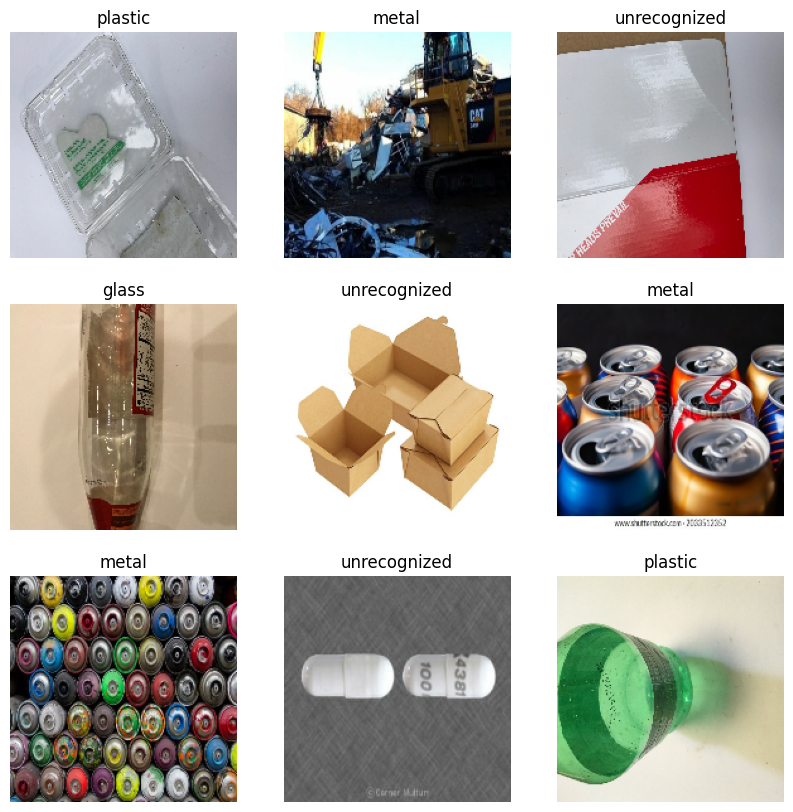

In [13]:
plt.figure(figsize=(10,10))
for image, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        displayed_image = (image[i].numpy()).astype('uint8')  # MULTIPLY THE .NUMPY() TO 255.0
        plt.imshow(displayed_image)
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.layers import Input

In [15]:
# I PERSONALLY ADD THIS DATA AUGMENTATION
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
])

In [16]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
# base_model.trainable = True
fine_tune_at = len(base_model.layers) - 10  # Unfreeze last 10 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation, # ADD THE DATA AUGMENTATION BEFORE THE PRE-TRAINED MODEL
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(len(data_cat), activation='softmax')  # Assuming a multi-class classification task
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# I ALSO CHANGED THIS, BUT I DON'T KNOW IF THERE'S CHANGES IN ITS PERFORMANCE

In [ ]:
epochs_size = 30 # I INCREASED THE TRAINING SIZE
history = model.fit(data_train, validation_data=data_val, epochs=epochs_size)

Epoch 1/30
55/55 [==============================] - 21s 311ms/step - loss: 0.8726 - accuracy: 0.5879 - val_loss: 0.4658 - val_accuracy: 0.8111
Epoch 2/30
55/55 [==============================] - 17s 298ms/step - loss: 0.4689 - accuracy: 0.8231 - val_loss: 0.3513 - val_accuracy: 0.8664
Epoch 3/30
55/55 [==============================] - 17s 296ms/step - loss: 0.3605 - accuracy: 0.8653 - val_loss: 0.2491 - val_accuracy: 0.9081
Epoch 4/30
55/55 [==============================] - 17s 296ms/step - loss: 0.2849 - accuracy: 0.8927 - val_loss: 0.2075 - val_accuracy: 0.9241
Epoch 5/30
55/55 [==============================] - 18s 303ms/step - loss: 0.2026 - accuracy: 0.9241 - val_loss: 0.1848 - val_accuracy: 0.9372
Epoch 6/30
55/55 [==============================] - 18s 305ms/step - loss: 0.1644 - accuracy: 0.9412 - val_loss: 0.1405 - val_accuracy: 0.9486
Epoch 7/30
55/55 [==============================] - 18s 301ms/step - loss: 0.1532 - accuracy: 0.9418 - val_loss: 0.1248 - val_accuracy: 0.9583

In [ ]:
epochs_range = range(epochs_size)
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

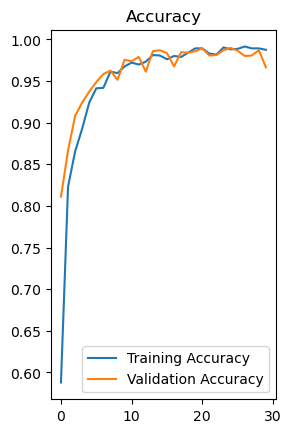

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

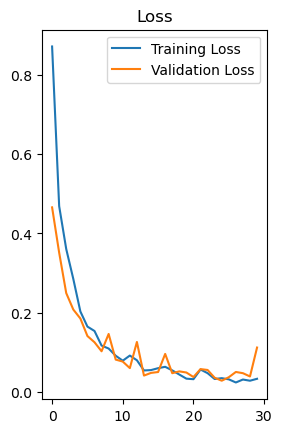

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:

image_path = r'C:\Users\Russuel\JN\basedata\basedata\test\metal\metal103.jpg'
image = tf.keras.utils.load_img(image_path, target_size=(img_height,img_width))
image_array = tf.keras.utils.img_to_array(image)
random_angle = np.random.uniform(-np.pi / 12, np.pi / 12)
rotated_image = tf.image.rot90(image_array, k=int(random_angle // (np.pi / 2)))
flipped_image = tf.image.random_flip_left_right(rotated_image)

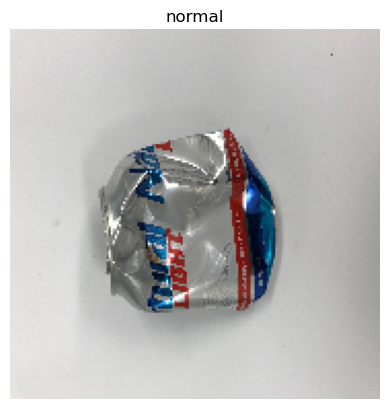

In [ ]:
plt.imshow(image_array.astype("uint8")) # predicting modified image
# plt.imshow(image_array.numpy().astype("uint8"))  # predicting modified image
plt.title('normal')
plt.axis('off')
plt.show()

In [ ]:
# normalized = image_array / 255.0
img_bat = tf.expand_dims(image_array, 0)
predict = model.predict(img_bat)
score = tf.nn.softmax(predict)

1/1 [==============================] - 0s 39ms/step


Trash in Image is metal with ACCURACY of 57.61%


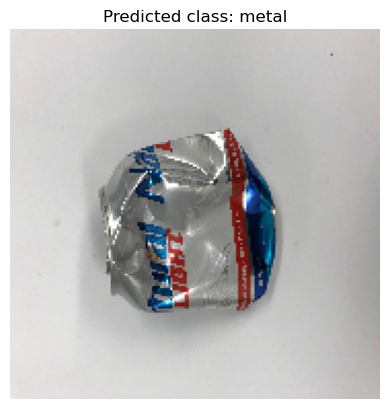

In [ ]:
print('Trash in Image is {} with ACCURACY of {:0.2f}%'.format(data_cat[np.argmax(score)], np.max(score)*100))

plt.figure(dpi=100)
plt.imshow(image_array.astype("uint8"))  # predicting non-modified image
# plt.imshow(rotated_image.numpy().astype("uint8"))  # predicting modified image
plt.title(f"Predicted class: {data_cat[np.argmax(score)]}")
plt.axis('off')
plt.show()

In [ ]:
import tensorflow_model_optimization as tfmot
print(tfmot.__file__)

C:\Users\Russuel\anaconda3\envs\gwithgpu\lib\site-packages\tensorflow_model_optimization\__init__.py


# **SAVE MODEL**

In [ ]:
model.save('./saved_model')

INFO:tensorflow:Assets written to: ./saved_model\assets


INFO:tensorflow:Assets written to: ./saved_model\assets


In [ ]:
import tensorflow as tf

model = tf.saved_model.load("./saved_model")

# Re-save the model in a format compatible with tfjs-node
tf.saved_model.save(model, "./savedModel")


INFO:tensorflow:Assets written to: ./savedModel\assets


INFO:tensorflow:Assets written to: ./savedModel\assets
